# BG-NBD and Gamma-Gamma CLTV Prediction

## Business Problem

FLO wants to determine a roadmap for sales and marketing activities. To make medium-long term plans, the company needs to predict the potential future value of existing customers.

## Dataset Story

The dataset consists of information obtained from the past shopping behaviors of customers who made their last purchases as OmniChannel (both online and offline) in 2020-2021.

### Features

- master_id: Unique customer number
- order_channel: Which channel of the shopping platform is used (Android, iOS, Desktop, Mobile, Offline)
- last_order_channel: The channel where the most recent purchase was made
- first_order_date: Date of the customer's first purchase
- last_order_date: Date of the customer's last purchase
- last_order_date_online: The date of the customer's last purchase on the online platform
- last_order_date_offline: The date of the customer's last purchase on the offline platform
- order_num_total_ever_online: Total number of purchases made by the customer on the online platform
- order_num_total_ever_offline: Total number of purchases made by the customer offline
- customer_value_total_ever_offline: Total amount paid by the customer for offline purchases
- customer_value_total_ever_online: Total amount paid by the customer for online purchases
- interested_in_categories_12: List of categories the customer has shopped in the last 12 months

## Tasks

### Task 1: Preparing the Data

1. Read the flo_data_20K.csv file and create a copy of the dataframe.
2. Define the outlier_thresholds and replace_with_thresholds functions needed to suppress outlier values.
   Note: When calculating cltv, frequency values must be integers. Therefore, round the lower and upper limits with round().
3. If there are outliers in the variables "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online", suppress them.
4. Omnichannel means that customers shop from both online and offline platforms. Create new variables for each customer's total purchases and spending.
5. Examine the variable types. Convert the type of variables that express a date to 'date'.

### Task 2: Creating the CLTV Data Structure

1. Take the date of 2 days after the last shopping in the dataset as the analysis date.
2. Create a new cltv dataframe containing customer_id, recency_cltv_weekly, T_weekly, frequency and monetary_cltv_avg.
   Monetary value will be expressed as the average value per purchase, and recency and tenure values will be expressed in weekly terms.

### Task 3: Establishing BG/NBD and Gamma-Gamma Models, Calculating CLTV

1. Fit the BG/NBD model.
   a. Estimate expected purchases from customers in 3 months and add to the cltv dataframe as exp_sales_3_month.
   b. Estimate expected purchases from customers in 6 months and add to the cltv dataframe as exp_sales_6_month.
2. Fit the Gamma-Gamma model. Estimate customers' average expected value and add it to the cltv dataframe as exp_average_value.
3. Calculate 6-month CLTV and add it to the dataframe with the name 'cltv'.
   a. Standardize the cltv values you calculated and create a scaled_cltv variable.
   b. Observe the 20 people with the highest CLTV value.

### Task 4: Creating Segments by CLTV

1. Divide all your customers into 4 groups (segments) according to 6-month standardized CLTV and add the group names to the dataset. Add to the dataframe with the name cltv_segment.
2. Make brief 6-month action suggestions to the management for 2 groups you will choose from the 4 groups.

### Task 5: Functionalize the entire process.


In [1]:
import pandas as pd
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

In [3]:
df_ = pd.read_csv("data/flo_data_20k.csv")
df = df_.copy()

In [4]:
def outlier_tresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [5]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_tresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

 3. Suppress outliers for the variables "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online"
 if they exist.

In [6]:
columns = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline","customer_value_total_ever_online"]
for col in columns:
    replace_with_thresholds(df, col)

Omnichannel customers are defined as those who shop from both online and offline platforms.
Create new variables for each customer's total number of purchases and total spending.

In [7]:
df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

 Examine the variable types. Convert the type of variables representing dates to date format.


In [8]:
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

Creating the CLTV Data Structure

In [9]:
df["last_order_date"].max()

Timestamp('2021-05-30 00:00:00')

In [10]:
analysis_date = dt.datetime(2021,6,1)

In [11]:
cltv_df = pd.DataFrame()
cltv_df["customer_id"] = df["master_id"]
cltv_df["recency_cltv_weekly"] = ((df["last_order_date"] - df["first_order_date"]).dt.days / 7)
cltv_df["T_weekly"] = ((analysis_date - df["first_order_date"]).dt.days / 7)
cltv_df["frequency"] = df["order_num_total"]
cltv_df["monetary_cltv_avg"] = df["customer_value_total"] / df["order_num_total"]


In [12]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99


TASK 3: Building BG/NBD and Gamma-Gamma Models, Calculating 6-month CLTV


In [13]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

c:\Users\asus\anaconda3\envs\miuul1env\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

In [14]:
cltv_df["exp_sales_3_month"] = bgf.predict(4*3,
                                            cltv_df['frequency'],
                                            cltv_df['recency_cltv_weekly'],
                                            cltv_df['T_weekly'])

In [15]:
cltv_df["exp_sales_6_month"] = bgf.predict(4*6,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])

In [19]:
cltv_df.sort_values("exp_sales_3_month", ascending=False)[:10]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52.50,164.63,4.70,9.40
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.71,40.00,29.00,165.30,3.37,6.75
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.86,33.29,25.00,97.44,3.14,6.28
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31.00,228.53,3.08,6.17
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.00,46.43,27.00,141.35,3.00,6.00
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.14,111.86,43.00,157.11,2.98,5.96
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.14,147.14,49.50,160.20,2.86,5.71
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.71,64.14,29.00,168.88,2.79,5.59
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17.00,259.87,2.78,5.56
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.57,113.43,40.00,176.20,2.76,5.53


In [18]:
cltv_df.sort_values("exp_sales_6_month",ascending=False)[:10]


,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52.50,164.63,4.70,9.40
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.71,40.00,29.00,165.30,3.37,6.75
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.86,33.29,25.00,97.44,3.14,6.28
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31.00,228.53,3.08,6.17
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.00,46.43,27.00,141.35,3.00,6.00
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.14,111.86,43.00,157.11,2.98,5.96
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.14,147.14,49.50,160.20,2.86,5.71
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.71,64.14,29.00,168.88,2.79,5.59
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17.00,259.87,2.78,5.56
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.57,113.43,40.00,176.20,2.76,5.53


In [21]:
cltv_df.dtypes

customer_id             object
recency_cltv_weekly    float64
T_weekly               float64
frequency              float64
monetary_cltv_avg      float64
exp_sales_3_month      float64
exp_sales_6_month      float64
dtype: object

In [24]:
cltv_df["frequency"] = cltv_df["frequency"].astype(int)

In [25]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                cltv_df['monetary_cltv_avg'])
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5,187.87,0.97,1.95,193.63
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21,95.88,0.98,1.97,96.67
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5,117.06,0.67,1.34,120.97
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2,60.98,0.70,1.40,67.32
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2,104.99,0.40,0.79,114.33


In [26]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6,
                                   freq="W",
                                   discount_rate=0.01)
cltv_df["cltv"] = cltv

In [27]:
cltv_df.sort_values("cltv",ascending=False)[:20]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.86,7.86,4,1401.77,1.09,2.19,1449.03,3327.71
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.14,13.14,11,758.04,1.97,3.94,767.32,3172.22
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.71,101.00,7,1106.47,0.72,1.44,1127.61,1708.98
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.29,74.57,16,501.85,1.57,3.13,506.14,1662.52
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.43,34.43,8,601.23,1.27,2.53,611.49,1623.81
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52,164.63,4.70,9.40,165.12,1613.30
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.29,9.43,2,862.69,0.79,1.59,923.68,1538.86
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17,259.87,2.78,5.56,262.07,1529.23
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31,228.53,3.08,6.17,229.61,1485.82
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.86,15.57,3,743.59,0.87,1.74,778.05,1423.00


SEGMENTATION

In [28]:
cltv_df["cltv_segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5,187.87,0.97,1.95,193.63,395.73,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21,95.88,0.98,1.97,96.67,199.43,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5,117.06,0.67,1.34,120.97,170.22,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2,60.98,0.70,1.40,67.32,98.95,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2,104.99,0.40,0.79,114.33,95.01,D


VISUALISATIONS

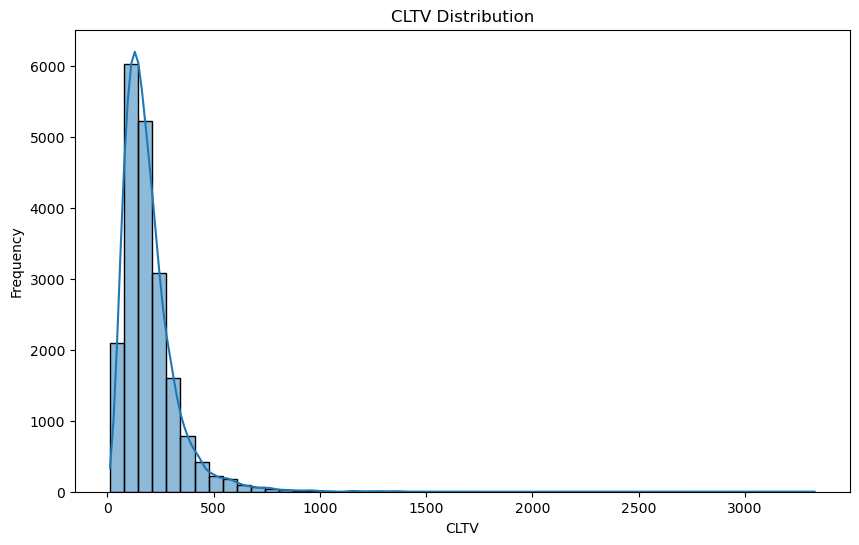

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# CLTV dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(cltv_df['cltv'], bins=50, kde=True)
plt.title('CLTV Distribution')
plt.xlabel('CLTV')
plt.ylabel('Frequency')
plt.savefig("reports/cltv_distribution.png")
plt.show()

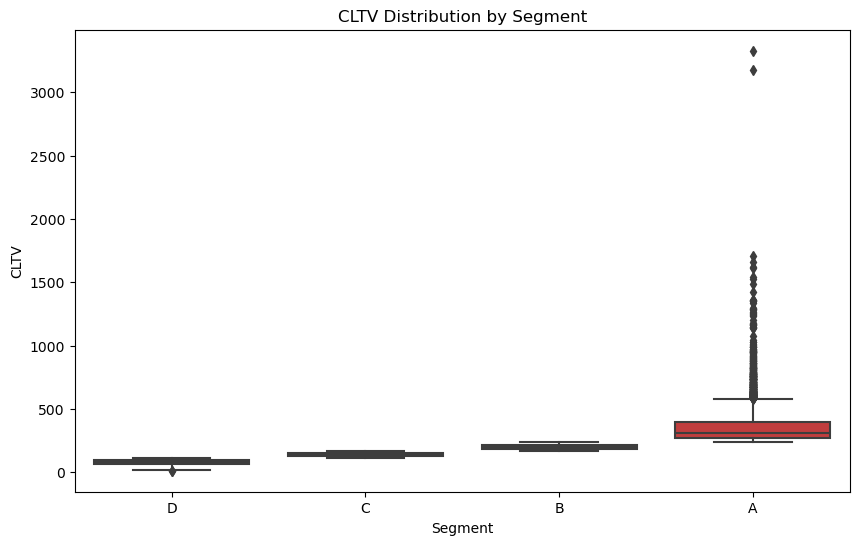

In [40]:
# Segmentlere göre CLTV dağılımı
plt.figure(figsize=(10, 6))
sns.boxplot(x='cltv_segment', y='cltv', data=cltv_df)
plt.title('CLTV Distribution by Segment')
plt.xlabel('Segment')
plt.ylabel('CLTV')
plt.savefig("reports/cltv_distribution_by_segment.png")
plt.show()

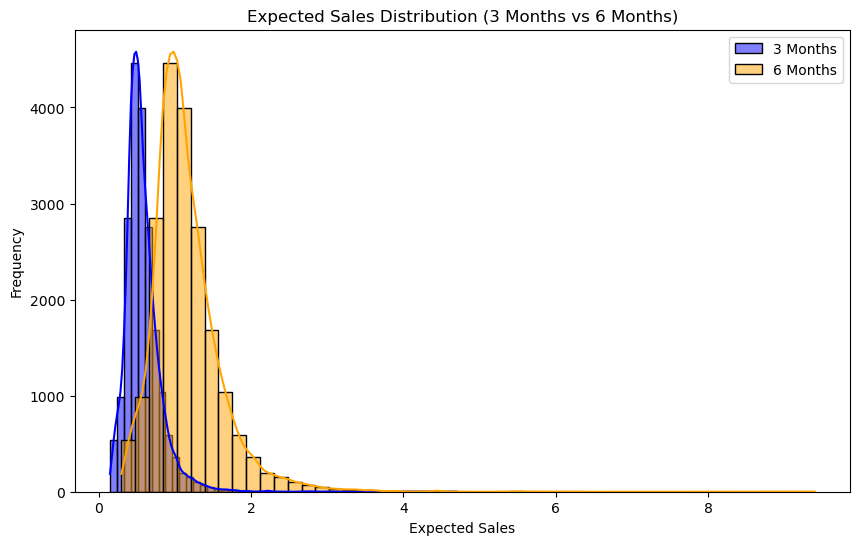

In [41]:
# Beklenen satışlar (3 ay ve 6 ay)
plt.figure(figsize=(10, 6))
sns.histplot(cltv_df['exp_sales_3_month'], bins=50, kde=True, color='blue', label='3 Months')
sns.histplot(cltv_df['exp_sales_6_month'], bins=50, kde=True, color='orange', label='6 Months')
plt.title('Expected Sales Distribution (3 Months vs 6 Months)')
plt.xlabel('Expected Sales')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("reports/expected_sales_distribution.png")

plt.show()

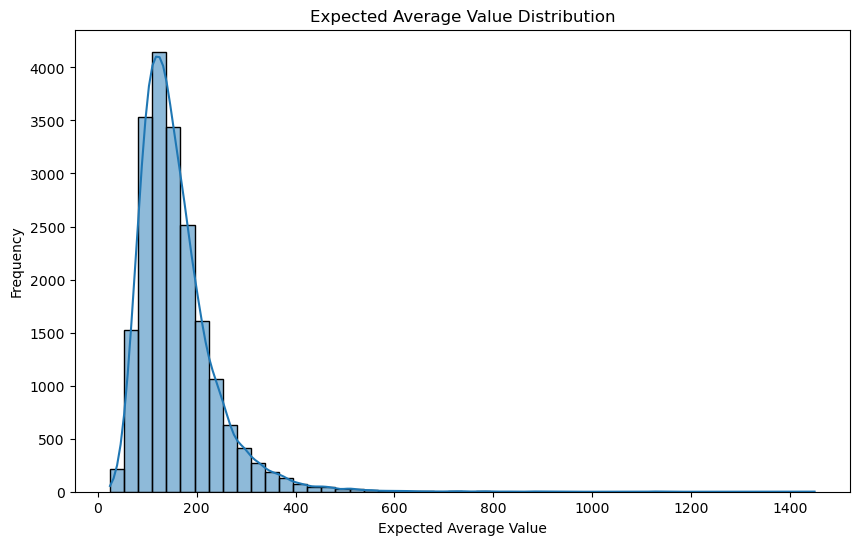

In [42]:
# Ortalama harcama değeri
plt.figure(figsize=(10, 6))
sns.histplot(cltv_df['exp_average_value'], bins=50, kde=True)
plt.title('Expected Average Value Distribution')
plt.xlabel('Expected Average Value')
plt.ylabel('Frequency')
plt.savefig("reports/expected_average_value_distribution.png")

plt.show()

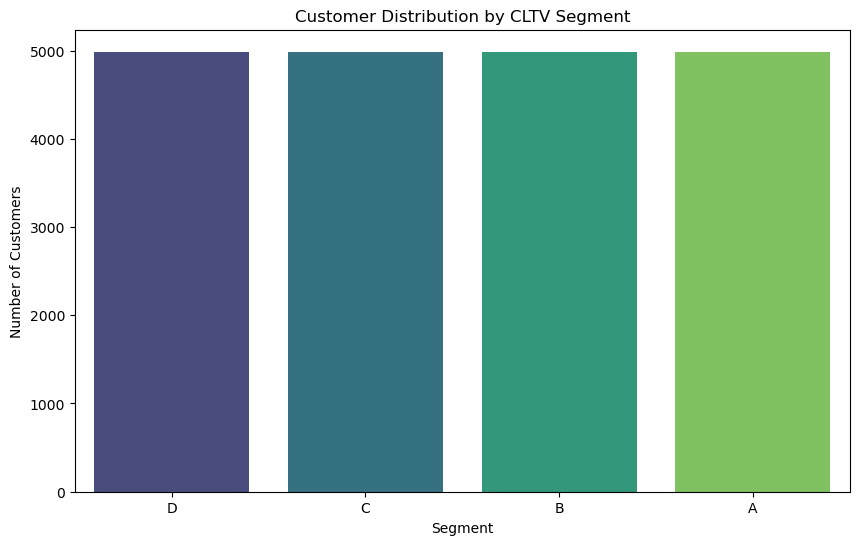

In [43]:
def plot_segment_distribution(cltv_df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='cltv_segment', data=cltv_df, palette='viridis')
    plt.title('Customer Distribution by CLTV Segment')
    plt.xlabel('Segment')
    plt.ylabel('Number of Customers')
    plt.savefig("reports/customer_distribution_by_cltv_segment.png")
    plt.show()

plot_segment_distribution(cltv_df)

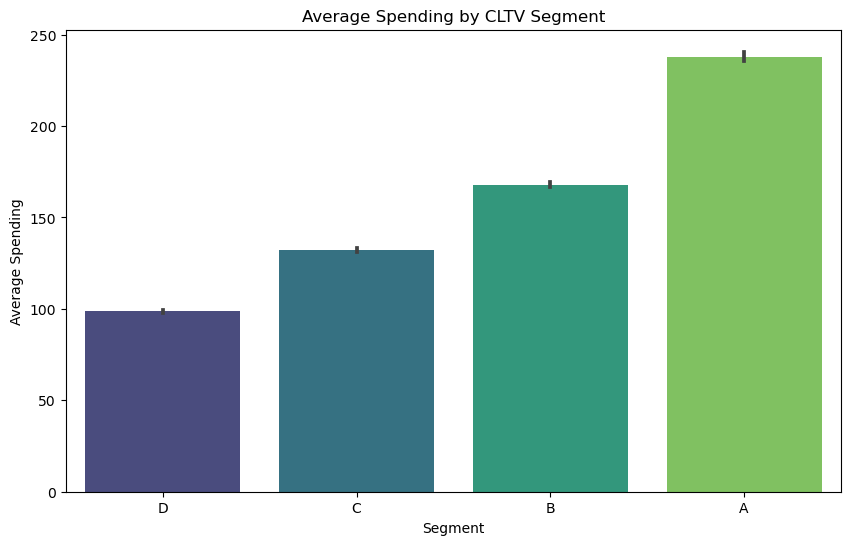

In [44]:
def plot_avg_value_by_segment(cltv_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='cltv_segment', y='exp_average_value', data=cltv_df, palette='viridis')
    plt.title('Average Spending by CLTV Segment')
    plt.xlabel('Segment')
    plt.ylabel('Average Spending')
    plt.savefig("reports/average_spending_by_cltv_segment.png")
    plt.show()

plot_avg_value_by_segment(cltv_df)

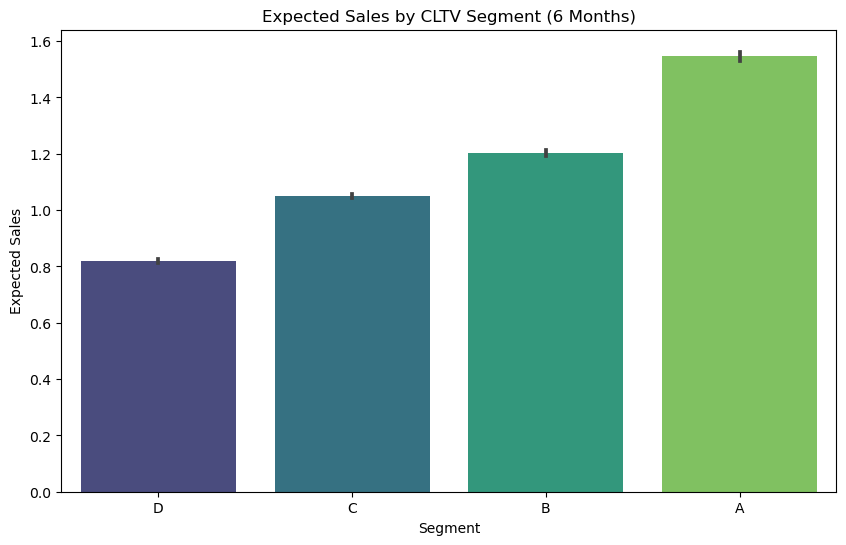

In [45]:
def plot_expected_sales_by_segment(cltv_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='cltv_segment', y='exp_sales_6_month', data=cltv_df, palette='viridis')
    plt.title('Expected Sales by CLTV Segment (6 Months)')
    plt.xlabel('Segment')
    plt.ylabel('Expected Sales')
    plt.savefig("reports/expected_sales_by_cltv_segment.png")
    plt.show()

plot_expected_sales_by_segment(cltv_df)

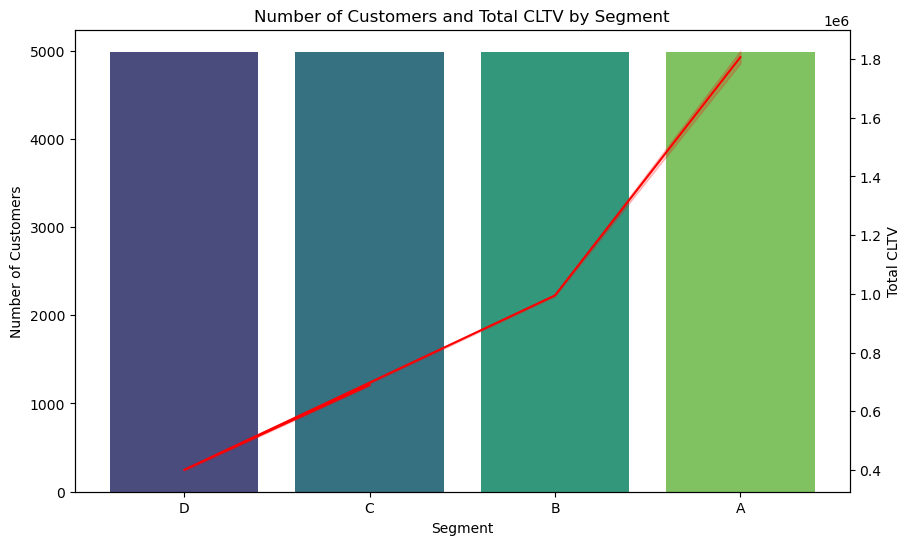

In [46]:
def plot_customers_and_cltv_by_segment(cltv_df):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    sns.countplot(x='cltv_segment', data=cltv_df, palette='viridis', ax=ax1)
    ax1.set_title('Number of Customers and Total CLTV by Segment')
    ax1.set_xlabel('Segment')
    ax1.set_ylabel('Number of Customers')

    ax2 = ax1.twinx()
    sns.lineplot(x='cltv_segment', y='cltv', data=cltv_df, estimator='sum', sort=False, color='red', ax=ax2)
    ax2.set_ylabel('Total CLTV')
    plt.savefig("reports/number_of_customers_and_total_cltv_by_segment.png")
    plt.show()

plot_customers_and_cltv_by_segment(cltv_df)

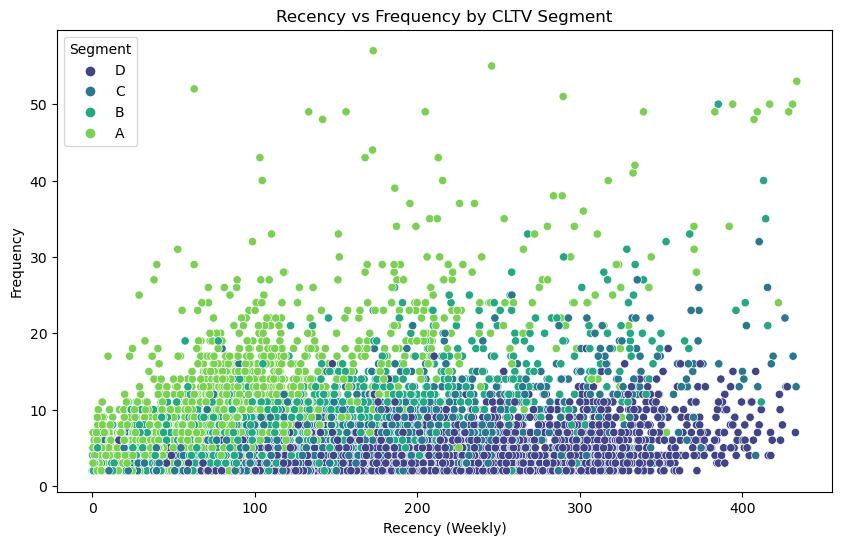

In [47]:
def plot_recency_frequency_by_segment(cltv_df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='recency_cltv_weekly', y='frequency', hue='cltv_segment', data=cltv_df, palette='viridis')
    plt.title('Recency vs Frequency by CLTV Segment')
    plt.xlabel('Recency (Weekly)')
    plt.ylabel('Frequency')
    plt.legend(title='Segment')
    plt.savefig("reports/recency_vs_frequency_by_cltv_segment.png")
    plt.show()

plot_recency_frequency_by_segment(cltv_df)